<center>
<img src="../../img/ods_stickers.jpg">

# <center> Homework \#8
## <center> Logistic regression for tagging questions from StackOverflow

**You have to infer some formulas where it is needed (yeah, you will need pen and paper), also you have to fill code where is is asked.**

## 0. Description

In this homework, we will study and program a model for predicting tags in the text of a question based on multiclass logistic regression. Unlike the usual statement of the classification problem (multiclass), in this case, one example can belong to several classes (multilabel) at the same time. We will implement the online version of the multilabel classification algorithm.

We will use a small sample of tagged questions from the StackOverflow website with a size of 125 thousand examples (find in the `data/hw8` folder).


PS: It can be shown that such an implementation is not at all effective and it would be easier to use vectorized calculations. For this dataset it is. But actually, such implementation is used in real life, but naturally, they are not written in Python. For example, a banner is shown to the user in the [CTR](https://en.wikipedia.org/wiki/Click-through_rate) forecasting online models, then, depending on the presence of a click, the model parameters are updated. In real life, the parameters of the model can be several hundred million. But usually, in such sparse data, not none parameters belonging to the user would be less than 100k. Often all this is stored in huge clusters in in-memory databases, and user processing is distributed.

PS2:
- in the process of solving homework, you will have to work with the text, and you may want to do obvious preprocessing, for example, put all the words in lower case, but  **you do not need to do this unless you are asked to do this**

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
from tqdm import tqdm
import pandas as pd
from collections import defaultdict
import gzip

# change it to your location
DS_FILE_NAME = '/Users/ashwin/work/data_science_bi/Ashwin/notebooks/mldubai/data/hw8/stackoverflow_sample_125k.tsv.gz'
TAGS_FILE_NAME = '/Users/ashwin/work/data_science_bi/Ashwin/notebooks/mldubai/data/hw8/top10_tags.tsv'

In [9]:
top_tags = []
with open(TAGS_FILE_NAME, 'r') as f:
    for line in f:
        top_tags.append(line.strip())
top_tags = set(top_tags)
print(top_tags)

{'c#', 'javascript', 'c++', 'jquery', 'ios', 'android', 'php', 'python', 'java', 'html'}


## 1. Multiclass and Multilabel Logistic Regression


Let's recap what is the Logistic Regression for binary classification $\left\{0, 1\right\}$. Probability that a sample belongs to a class $1$ can be inferred using [Bayes Formula](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$\large \begin{array}{rcl}
p\left(c = 1 \mid \vec{x}\right) &=& \dfrac{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right)}{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right) + p\left(\vec{x} \mid c = 0\right)p\left(c = 0\right)} \\
&=& \dfrac{1}{1 + e^{-a}} \\
&=& \sigma\left(a\right)
\end{array}$$
where:
- $\vec{x}$ – features of the sample
- $\sigma$ – logistic sigmoid function
- $a = \log \frac{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right)}{p\left(\vec{x} \mid c = 0\right)p\left(c = 0\right)} = \sum_{i=0}^M w_i x_i$ – log odds is modelled by a linear function

We can generalize it to a set of $K$ classes, only denominator will be changed in the Bayes Formula. Let's write down a probability of belonging to a class $k$:
$$\large \begin{array}{rcl}
p\left(c = k \mid \vec{x}\right) &=& \dfrac{p\left(\vec{x} \mid c = k\right)p\left(c = k\right)}{\sum_{i=1}^K p\left(\vec{x} \mid c = i\right)p\left(c = i\right)} \\
&=& \dfrac{e^{z_k}}{\sum_{i=1}^{K}e^{z_i}} \\
&=& \sigma_k\left(\vec{z}\right)
\end{array}$$
где:
- $\sigma_k$ – a [softmax function](https://en.wikipedia.org/wiki/Softmax_function)
- $z_k = \log p\left(\vec{x} \mid c = k\right)p\left(c = k\right) = \sum_{i=0}^M w_{ki} x_i$ – now instead of one line which separates two classes, we have several lines for each class $k$ which separates it from all others

We use [categorical disribution](https://en.wikipedia.org/wiki/Categorical_distribution) for a likelihood function, or it's log:

$$\large \begin{array}{rcl}
\mathcal{L} = \log p\left({\vec{x}}\right) &=& \log \prod_{i=1}^K \sigma_i\left(\vec{z}\right)^{y_i} \\
&=& \sum_{i=1}^K y_i \log \sigma_i\left(\vec{z}\right)
\end{array}$$

This is well known [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) function (after multiplication to $-1$). Usually we maximize likelihood, but in the case of cross entropy we minimize it (because cross entropy is a measure between two distributions, and we want to move closer model distribution to a ground truth). To infer rule of updating weights we have to take a derivative wrt parameters, **plz do it if you have never done it before** (here is the solution [one](https://www.ics.uci.edu/~pjsadows/notes.pdf) and [two](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/)):

$$\large \begin{array}{rcl}
\frac{\partial \mathcal{L}}{\partial w_{km}} &=& x_m \left(y_k - \sigma_k\left(\vec{z}\right)\right)
\end{array}$$

Vector of softmax values $\left(\sigma_1, \sigma_2, \ldots, \sigma_K\right)$ forms a discrete probability distribution, i.e. $\sum_{i=1}^K \sigma_i = 1$. But in our setup each sample may have one or more tags, or belongs to one or more classes. We modify the model:
- let's consider that each tag is independant from others, i.e. for each outcome we use binary logistic regression (either sample has the tag or not); then we can write down probabilities of a tag of the sample:
$$\large p\left(\text{tag}_k \mid \vec{x}\right) = \sigma\left(z_k\right) = \sigma\left(\sum_{i=1}^M w_{ki} x^i \right)$$
- like in LR, presence of a tag we model by <a href="https://en.wikipedia.org/wiki/Bernoulli_distribution">Bernoulli distribution</a>

<font color="red">Question 1.</font> Your first task – is to infer and write down simplified loss function, which is negative log of likelihood of features of a sample $\vec{x}$. 

<font color="red">Options:</font>
1. $\large -\mathcal{L} = -\sum_{i=1}^M y_i \log \sigma\left(z_i\right) + \left(1 - y_i\right) \log \left(1 - \sigma\left(z_i\right)\right)$
2. $\large -\mathcal{L} = -\sum_{i=1}^K y_i \log \sigma\left(z_i\right) + \left(1 - y_i\right) \log \left(1 - \sigma\left(z_i\right)\right)$
3. $\large -\mathcal{L} = -\sum_{i=1}^K z_i \log \sigma\left(y_i\right) + \left(1 - z_i\right) \log \left(1 - \sigma\left(y_i\right)\right)$
4. $\large -\mathcal{L} = -\sum_{i=1}^M z_i \log \sigma\left(y_i\right) + \left(1 - z_i\right) \log \left(1 - \sigma\left(y_i\right)\right)$

In [10]:
print("Option 2 is correct")

Option 2 is correct


## 2. Update rule inference

<font color="red">Question 2.</font>Infer and write down an updating rule of parameters of the model, taking derivative of $-\mathcal{L}$.

<font color="red">Options:</font>:
1. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = -x_m \left(\sigma\left(z_k\right) - y_k\right)$
2. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = -x_m \left(y_k - \sigma\left(z_k\right)\right)$
3. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = \left(\sigma\left(z_k\right)x_m - y_k\right)$
4. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = \left(y_k - \sigma\left(z_k\right)x_m\right)$

In [11]:
print("Option 2 is correct")

Option 2 is correct


## 3. Implementation of the base model

### Shortest introduction to text processing

<img src='/Users/ashwin/work/data_science_bi/Ashwin/notebooks/mldubai/img/Bag-Of-Words-BOW-representation-of-the-input-that-is-next-follow-by-Softmax.png' />

### Description of the base class

In this exercise, you have a facade of the class, study it carefully, pay attention to all comments in the code. Then plz fill gaps in the code where is it asked.

As you may notice from the code, for updating parameter $w_{km}$ we use only feature $x_m$, which equals to $0$ if there is now word with index $m$ in the sentence, and greater then $0$ if there is such word. In our case, if we don't want to recalculate [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) for the incoming sentence, we are iterating over words of the sentence in the order of the sentence. If a word occurs several times, then we add it to the cummolative variable with its weight. **When you accumulate linear combination of words and parameters in $z$, you should count only non-zero features of an object.**

Hint:
- if you implement calculation of the sigmoid function in a straightforward way like in formula, then big negative $z$ will give you large value of $e^{-z}$ which may exceed limits of `float32`
- meanwhile $e^{-z}$ of big positive $z$ will be zero
- use properties of $\sigma$ to fix this numerical issue, to avoid overflow.

#### class LogRegressor():
    
    """Constructor of the class
    
    Parameters
    ----------
    tags : list of string, default=top_tags
        list of all tags
    """
    def __init__(self, tags=top_tags):      
        # dictionary which conains mapping from words to indices (to save memory)
        # e.g. self._vocab['exception'] = 17 means that word `exception` has index equal to 17
        self._vocab = {}
        
        # parameters of the model / weights
        # for each class/tag we have to store its own vector of weights
        # by default all weights equal to zero
        # in advance we don't know total number of parameters, because we don't know the size of the vacabulary
        # so for each class we have dictionary wich variable number of keys stored there
        # e.g. self._w['java'][self._vocab['exception']]  is a weight of word `exception` for tag `java`
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # parameter of the model: w_0 or bias
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """One iteration over dataset
    
    Parameters
    ----------
    fname : string, default=DS_FILE_NAME
        file name with the data
        
    top_n_train : int
        first top_n_train lines will be used for training, the rest for testing
        
    total : int, default=125000
        total number of line, used only to show progress par
    
    learning_rate : float, default=0.1
        learning rate of gradient decsent algorithm
        
    tolerance : float, default=1e-16
        tolerance of log
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16):
        
        self._loss = []
        n = 0
        
        # open gzipped text file
        with gzip.open(fname, 'rb') as f:
            
            # iterate over lines in the file
            for line in tqdm(f, total=total, mininterval=1):
                pair = line.decode().strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # words of the sentence, these are features x
                sentence = sentence.split(' ')
                # tags of the sentence, these are targets y
                tags = set(tags.split(' '))
                
                # loss of the current sample
                sample_loss = 0

                # calculate gradients and update weights
                # iterate over tags, because each tag has its own list of parameters
                for tag in self._tags:
                    # target variable is 1 if a tag is in the set of tags of the current sentence
                    y = int(tag in tags)
                    
                    # calculation of the argument of sigmoind
                    # linear combination of weights and features
                    # here we initialize z with some value
                    # FILL GAP IN THE CODE
                    # z = ... 
                    # initially all wights will be 0, only w0
                    z = self._b[tag]
   
                    for word in sentence:
                        # if in the testing mode we have word which was not seen in the training part
                        # we ignore it
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        # update z
                        # FILL GAP IN THE CODE
                        # z += ...
                        # wx = weight of word in tag * index of work in sentence
                        z += self._w[tag][self._vocab[word]] * self._vocab[word]
    
                    # calculate value of the sigmoid function
                    # FILL GAP IN THE CODE
                    # sigma = ...
#                     sigma = 1/(1 + np.exp(-z))
                    sigma = np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))
    
                    # update smaple loss value
                    # FILL GAP IN THE CODE
                    # sample_loss += ...
                    sample_loss += -np.log(max(sigma, tolerance)) if y == 1 else\
                                   np.log(1- min(sigma, tolerance))
                 
                    
                    # if we are in the training part of the dataset, we update weights
                    if n < top_n_train:
                        # calculate derivative of the loss function wrt parameter
                        # FILL GAP IN THE CODE
                        # dLdw = ... 

                        # update weights
                        # we minimize negatime log likelihood (the second minus sign)
                        # why we follow negative direction of the gradient (the first minus sign)
                        
                        for word in sentence:           
                            dLdw = self._vocab[word] * ( y - sigma)
                            self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                        self._b[tag] -= -learning_rate*dLdw
                    
                n += 1
                        
                self._loss.append(sample_loss)

In [13]:
# let's create an instance of the object and iterate through dataset 
model = LogRegressor()
model.iterate_file()

  0%|          | 0/125000 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 125000/125000 [10:21<00:00, 200.98it/s]


Check if the value of the negative log likelihood really decreased. Since we use stochastic gradient descent, we should not expect a smooth fall in the error function. We will use a moving average with a window of 10 thousand examples to somehow smooth out the chart.

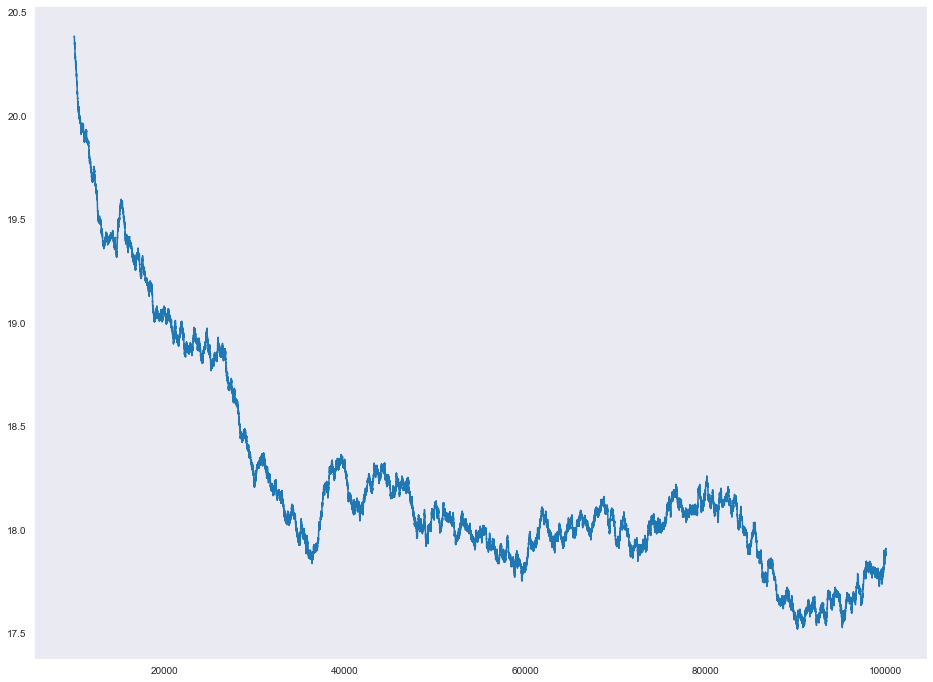

In [14]:
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

In [15]:
print('Mean of the loss function on the last 10k train samples: %0.2f' % np.mean(model._loss[-35000:-25000]))

Mean of the loss function on the last 10k train samples: 17.90


<font color="red">Question 3.</font>
Calculate mean value of the loss function on the last 10 000 examples of testing set. Choose the closest answer to yours from he following list.

<font color="red">Options:</font>
1. 17.54
2. 18.64
3. 19.74
4. 20.84

In [16]:
print("Option 1 is correct")

Option 1 is correct


## 4. Тестирование модели

In the base model we used first 100 000 line for training, and the rest for testing. As you may see, value of negative log likelihood is not very informative. You have to modify the base model, such that `iterate_file` would return value of _accuracy_ on the test set. 

We define accuracy as:
- we consider a threshold equal to `0.9`, if the predicted probability of a tag is greater then the threshold, we consder that the input sentence has the tag
- we calculate accuracy using [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index) between the set of predicted tags and the set of ground truth tags
  - e.g. if a sentence has two tags ['html', 'jquery'], but model predicted three ['ios', 'html', 'java'], then Jaccard index equals to |['html', 'jquery'] $\cap$ ['ios', 'html', 'java']| / |['html', 'jquery'] $\cup$ ['ios', 'html', 'java']| = |['html']| / |['jquery', 'ios', 'html', 'java']| = 1/4
- method `iterate_file` returns **average** accuracy on testing set

In [17]:
# UPDATE LogRegressor CLASS
# Put the new version of the class here
# FILL GAP IN THE CODE

In [18]:
class LogRegressor():
    
    """Constructor of the class
    
    Parameters
    ----------
    tags : list of string, default=top_tags
        list of all tags
    """
    def __init__(self, tags=top_tags):      
        # dictionary which conains mapping from words to indices (to save memory)
        # e.g. self._vocab['exception'] = 17 means that word `exception` has index equal to 17
        self._vocab = {}
        
        # parameters of the model / weights
        # for each class/tag we have to store its own vector of weights
        # by default all weights equal to zero
        # in advance we don't know total number of parameters, because we don't know the size of the vacabulary
        # so for each class we have dictionary wich variable number of keys stored there
        # e.g. self._w['java'][self._vocab['exception']]  is a weight of word `exception` for tag `java`
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # parameter of the model: w_0 or bias
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """One iteration over dataset
    
    Parameters
    ----------
    fname : string, default=DS_FILE_NAME
        file name with the data
        
    top_n_train : int
        first top_n_train lines will be used for training, the rest for testing
        
    total : int, default=125000
        total number of line, used only to show progress par
    
    learning_rate : float, default=0.1
        learning rate of gradient decsent algorithm
        
    tolerance : float, default=1e-16
        tolerance of log
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16):
        
        self._loss = []
        self._acc = []
        n = 0
        
        # open gzipped text file
        with gzip.open(fname, 'rb') as f:
            
            # iterate over lines in the file
            for line in tqdm(f, total=total, mininterval=1):
                pair = line.decode().strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # words of the sentence, these are features x
                sentence = sentence.split(' ')
                # tags of the sentence, these are targets y
                tags = set(tags.split(' '))
                
                # loss of the current sample
                sample_loss = 0

                # calculate gradients and update weights
                # iterate over tags, because each tag has its own list of parameters
                predicted_tags = []
                for tag in self._tags:
                    # target variable is 1 if a tag is in the set of tags of the current sentence
                    y = int(tag in tags)
                    
                    # calculation of the argument of sigmoind
                    # linear combination of weights and features
                    # here we initialize z with some value
                    # FILL GAP IN THE CODE
                    # z = ... 
                    # initially all wights will be 0, only w0
                    z = self._b[tag]
   
                    for word in sentence:
                        # if in the testing mode we have word which was not seen in the training part
                        # we ignore it
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        # update z
                        # FILL GAP IN THE CODE
                        # z += ...
                        # wx = weight of word in tag * index of work in sentence
                        z += self._w[tag][self._vocab[word]] * self._vocab[word]
    
                    # calculate value of the sigmoid function
                    # FILL GAP IN THE CODE
                    # sigma = ...
#                     sigma = 1/(1 + np.exp(-z))
                    sigma = np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))
    
                    
                    # update smaple loss value
                    # FILL GAP IN THE CODE
                    # sample_loss += ...
                    sample_loss += -np.log(max(sigma, tolerance)) if y == 1 else\
                                   np.log(1- min(sigma, tolerance))
                 
                    
                    # if we are in the training part of the dataset, we update weights
                    if n < top_n_train:
                        # calculate derivative of the loss function wrt parameter
                        # FILL GAP IN THE CODE
                        # dLdw = ... 

                        # update weights
                        # we minimize negatime log likelihood (the second minus sign)
                        # why we follow negative direction of the gradient (the first minus sign)
                        for word in sentence:                        
                            dLdw = self._vocab[word] * ( y - sigma)
                            self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                        self._b[tag] -= -learning_rate*dLdw
                    else:
                        if sigma > 0.9:
                            predicted_tags.append(tag)
                if n >= top_n_train:
                    self._acc.append(len(tags.intersection(set(predicted_tags))) / len(tags.union(predicted_tags)))
                n += 1
                        
                self._loss.append(sample_loss)
            return np.mean(self._acc)

In [19]:
model = LogRegressor()
acc = model.iterate_file()
# print accuracy
print('%0.2f' % acc)
print("Option 2 is correct")

  0%|          | 0/125000 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 125000/125000 [10:17<00:00, 202.57it/s]

0.49
Option 2 is correct


<font color="red">Question 4.</font> Find the closest answer to the printed accuracy from the following list?

<font color="red">Options:</font>
1. 0.39
2. 0.49
3. 0.59
4. 0.69

## 5. $L_2$-regilarization

Your fifth task is to upgrade the model `LogRegressor` such that it would support $L_2$-regularization. In the method `iterate_file` should be rarameter `lmbda=0.01` with the default value. Takin into account regilarization, new loss function wil be:

$$\large \begin{array}{rcl}
L &=& -\mathcal{L} + \frac{\lambda}{2} R\left(W\right) \\
&=& -\mathcal{L} + \frac{\lambda}{2} \sum_{k=1}^K\sum_{i=1}^M w_{ki}^2
\end{array}$$

Gradient of the first term we have already inferred, for the second one it is:

$$\large \begin{array}{rcl}
\frac{\partial}{\partial w_{ki}} \frac{\lambda}{2} R\left(W\right) &=& \lambda w_{ki}
\end{array}$$

If we would regularize ALL weights for each sentence we will slow down the process dramatically, because we will need to iterate over vacabulary for each sentence. But we will use dirty trick from real life, which would drop quality a bit, but boost computational performace: we will apply rerularization only for such parameters which correspondant words are presented in the sentence. Don't forget, that we don't regularize bias/w_0. Also do not modify `sample_loss`, calculate it without regularization.

Hint:
- don't forget, that you need to regularize parameter once, even if there were several correspondant words
- let's agree to regularize a parameter, only if we see its word for a first time

In [20]:
# UPDATE LogRegressor CLASS
# Put the new version of the class here
# FILL GAP IN THE CODE

In [21]:
class LogRegressor():
    
    """Constructor of the class
    
    Parameters
    ----------
    tags : list of string, default=top_tags
        list of all tags
    """
    def __init__(self, tags=top_tags):      
        # dictionary which conains mapping from words to indices (to save memory)
        # e.g. self._vocab['exception'] = 17 means that word `exception` has index equal to 17
        self._vocab = {}
        
        # parameters of the model / weights
        # for each class/tag we have to store its own vector of weights
        # by default all weights equal to zero
        # in advance we don't know total number of parameters, because we don't know the size of the vacabulary
        # so for each class we have dictionary wich variable number of keys stored there
        # e.g. self._w['java'][self._vocab['exception']]  is a weight of word `exception` for tag `java`
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # parameter of the model: w_0 or bias
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """One iteration over dataset
    
    Parameters
    ----------
    fname : string, default=DS_FILE_NAME
        file name with the data
        
    top_n_train : int
        first top_n_train lines will be used for training, the rest for testing
        
    total : int, default=125000
        total number of line, used only to show progress par
    
    learning_rate : float, default=0.1
        learning rate of gradient decsent algorithm
        
    tolerance : float, default=1e-16
        tolerance of log
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16,
                     lmbda=0.01):
        
        self._loss = []
        self._acc = []
        n = 0
        tag_word = set()
        
        # open gzipped text file
        with gzip.open(fname, 'rb') as f:
            
            # iterate over lines in the file
            for line in tqdm(f, total=total, mininterval=1):
                pair = line.decode().strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # words of the sentence, these are features x
                sentence = sentence.split(' ')
                # tags of the sentence, these are targets y
                tags = set(tags.split(' '))
                
                # loss of the current sample
                sample_loss = 0

                # calculate gradients and update weights
                # iterate over tags, because each tag has its own list of parameters
                predicted_tags = []
                for tag in self._tags:
                    # target variable is 1 if a tag is in the set of tags of the current sentence
                    y = int(tag in tags)
                    
                    # calculation of the argument of sigmoind
                    # linear combination of weights and features
                    # here we initialize z with some value
                    # FILL GAP IN THE CODE
                    # z = ... 
                    # initially all wights will be 0, only w0
                    z = self._b[tag]
   
                    for word in sentence:
                        # if in the testing mode we have word which was not seen in the training part
                        # we ignore it
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        # update z
                        # FILL GAP IN THE CODE
                        # z += ...
                        # wx = weight of word in tag * index of work in sentence
                        z += self._w[tag][self._vocab[word]] * self._vocab[word]
    
                    # calculate value of the sigmoid function
                    # FILL GAP IN THE CODE
                    # sigma = ...
#                     sigma = 1/(1 + np.exp(-z))
                    sigma = np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))
    
                    
                    # update smaple loss value
                    # FILL GAP IN THE CODE
                    # sample_loss += ...
                    sample_loss += -np.log(max(sigma, tolerance)) if y == 1 else\
                                   np.log(1- min(sigma, tolerance))
                 
                    
                    # if we are in the training part of the dataset, we update weights
                    if n < top_n_train:
                        # calculate derivative of the loss function wrt parameter
                        # FILL GAP IN THE CODE
                        # dLdw = ... 

                        # update weights
                        # we minimize negatime log likelihood (the second minus sign)
                        # why we follow negative direction of the gradient (the first minus sign)
                        for word in sentence: 
                            # adding few commented code which heelps to regularize only for first time seeing word
                            # but for first seing word, weight is 0
#                             if tag+word not in tag_word :
#                                 if(self._w[tag][self._vocab[word]] != 0):
#                                     print("r2 is applied")
#                                     print(self._w[tag][self._vocab[word]])
#                                 dLdw = (-1 * self._vocab[word] * ( y - sigma)) + (lmbda * self._w[tag][self._vocab[word]])
#                                 tag_word.add(tag+word)
#                             else:
#                                 dLdw = (-1 * self._vocab[word] * ( y - sigma))
                            dLdw = (-1 * self._vocab[word] * ( y - sigma))
                            regulazation_param = (lmbda * self._w[tag][self._vocab[word]])
                            self._w[tag][self._vocab[word]] -= learning_rate*(dLdw + regulazation_param)
                        self._b[tag] -= learning_rate*dLdw
                    else:
                        if sigma > 0.9:
                            predicted_tags.append(tag)
                if n >= top_n_train:
                    self._acc.append(len(tags.intersection(set(predicted_tags))) / len(tags.union(predicted_tags)))
                n += 1
                        
                self._loss.append(sample_loss)
            return np.mean(self._acc)

  0%|          | 0/125000 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 125000/125000 [16:13<00:00, 128.40it/s]


0.44
Option 3 is correct


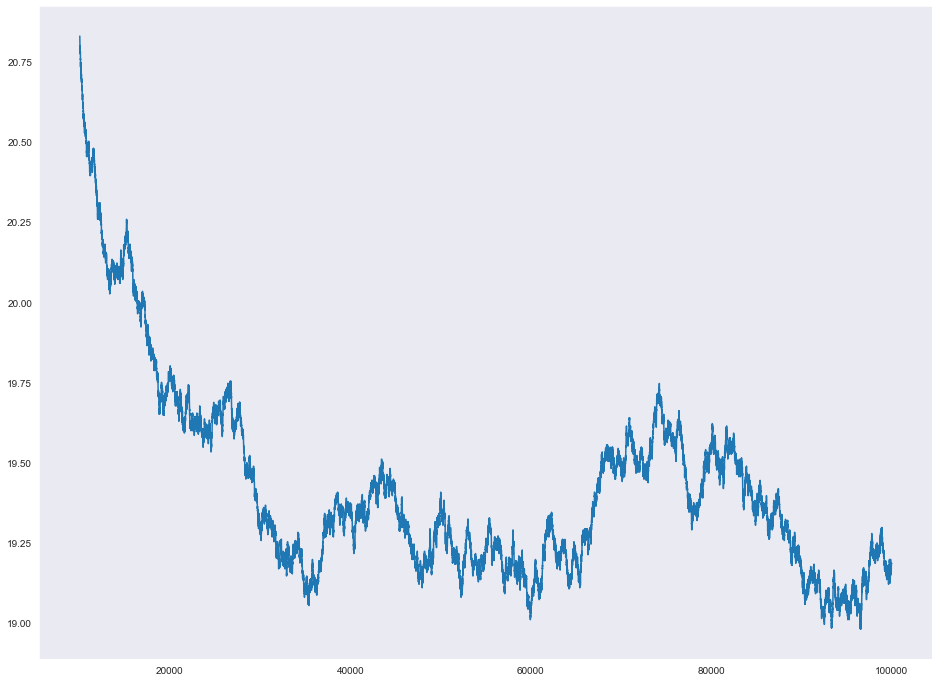

In [22]:
model = LogRegressor()
acc = model.iterate_file()
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());
print("Option 3 is correct")

<font color="red">Question 5.</font> Find the closest answer to the printed accuracy from the following list?

<font color="red">Options:</font>
1. 0.3
2. 0.35
3. 0.4
4. 0.52

## 6. ElasticNet Regularization, formulas
Beside $L_2$ regularization, $L_1$ is used quite often.

$$\large \begin{array}{rcl}
L &=& -\mathcal{L} + \frac{\lambda}{2} R\left(W\right) \\
&=& -\mathcal{L} + \lambda \sum_{k=1}^K\sum_{i=1}^M \left|w_{ki}\right|
\end{array}$$

ElasticNet is a linear combination of $L_1$ and $L_2$:

$$\large \begin{array}{rcl}
L &=& -\mathcal{L} + \lambda R\left(W\right) \\
&=& -\mathcal{L} + \lambda \left(\gamma \sum_{k=1}^K\sum_{i=1}^M w_{ki}^2 + \left(1 - \gamma\right) \sum_{k=1}^K\sum_{i=1}^M \left|w_{ki}\right| \right)
\end{array}$$
- where $\gamma \in \left[0, 1\right]$

<font color="red">Question 6.</font> Find a gradient of ElasticNet (do not take into account $-\mathcal{L}$ for now). 

<font color="red">Options:</font>:
1. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(2 \gamma w_{ki} + \left(1 - \gamma\right) w_{ki}\right)$ 
2. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(2 \gamma \left|w_{ki}\right| + \left(1 - \gamma\right) \text{sign}\left(w_{ki}\right)\right)$
3. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(2 \gamma w_{ki} + \left(1 - \gamma\right) \text{sign}\left(w_{ki}\right)\right)$
4. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(\gamma w_{ki} + \left(1 - \gamma\right) \text{sign}\left(w_{ki}\right)\right)$

In [23]:
print("Option 3 is correct")

Option 3 is correct


## 7. ElasticNet Regularization, implementation

Please update `LogRegressor` so that it would support `ElasticNet`. Method `iterate_file` now should take `lmbda=0.0002` and `gamma=0.1`. Run one pass over dataset with `ElasticNet` and default values.

In [24]:
# UPDATE LogRegressor CLASS
# Put the new version of the class here
# FILL GAP IN THE CODE

In [25]:
class LogRegressor():
    
    """Constructor of the class
    
    Parameters
    ----------
    tags : list of string, default=top_tags
        list of all tags
    """
    def __init__(self, tags=top_tags):      
        # dictionary which conains mapping from words to indices (to save memory)
        # e.g. self._vocab['exception'] = 17 means that word `exception` has index equal to 17
        self._vocab = {}
        
        # parameters of the model / weights
        # for each class/tag we have to store its own vector of weights
        # by default all weights equal to zero
        # in advance we don't know total number of parameters, because we don't know the size of the vacabulary
        # so for each class we have dictionary wich variable number of keys stored there
        # e.g. self._w['java'][self._vocab['exception']]  is a weight of word `exception` for tag `java`
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # parameter of the model: w_0 or bias
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """One iteration over dataset
    
    Parameters
    ----------
    fname : string, default=DS_FILE_NAME
        file name with the data
        
    top_n_train : int
        first top_n_train lines will be used for training, the rest for testing
        
    total : int, default=125000
        total number of line, used only to show progress par
    
    learning_rate : float, default=0.1
        learning rate of gradient decsent algorithm
        
    tolerance : float, default=1e-16
        tolerance of log
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16,
                     lmbda=0.0002,
                     gamma = 0.1):
        
        self._loss = []
        self._acc = []
        n = 0
        tag_word = set()
        
        # open gzipped text file
        with gzip.open(fname, 'rb') as f:
            
            # iterate over lines in the file
            for line in tqdm(f, total=total, mininterval=1):
                pair = line.decode().strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # words of the sentence, these are features x
                sentence = sentence.split(' ')
                # tags of the sentence, these are targets y
                tags = set(tags.split(' '))
                
                # loss of the current sample
                sample_loss = 0

                # calculate gradients and update weights
                # iterate over tags, because each tag has its own list of parameters
                predicted_tags = []
                for tag in self._tags:
                    # target variable is 1 if a tag is in the set of tags of the current sentence
                    y = int(tag in tags)
                    
                    # calculation of the argument of sigmoind
                    # linear combination of weights and features
                    # here we initialize z with some value
                    # FILL GAP IN THE CODE
                    # z = ... 
                    # initially all wights will be 0, only w0
                    z = self._b[tag]
   
                    for word in sentence:
                        # if in the testing mode we have word which was not seen in the training part
                        # we ignore it
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        # update z
                        # FILL GAP IN THE CODE
                        # z += ...
                        # wx = weight of word in tag * index of work in sentence
                        z += self._w[tag][self._vocab[word]] * self._vocab[word]
    
                    # calculate value of the sigmoid function
                    # FILL GAP IN THE CODE
                    # sigma = ...
#                     sigma = 1/(1 + np.exp(-z))
                    sigma = np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))
    
                    
                    # update smaple loss value
                    # FILL GAP IN THE CODE
                    # sample_loss += ...
                    sample_loss += -np.log(max(sigma, tolerance)) if y == 1 else\
                                   np.log(1- min(sigma, tolerance))
                 
                    
                    # if we are in the training part of the dataset, we update weights
                    if n < top_n_train:
                        # calculate derivative of the loss function wrt parameter
                        # FILL GAP IN THE CODE
                        # dLdw = ... 

                        # update weights
                        # we minimize negatime log likelihood (the second minus sign)
                        # why we follow negative direction of the gradient (the first minus sign)
                        for word in sentence:        
                            if tag+word not in tag_word :
                                dLdw = (-1 * self._vocab[word] * ( y - sigma)) + (lmbda * ((2 * gamma * self._w[tag][self._vocab[word]]) + ((1 - gamma) * np.sign(self._w[tag][self._vocab[word]]))))    
                                tag_word.add(tag+word)
                            else:
                                dLdw = (-1 * self._vocab[word] * ( y - sigma))
                            self._w[tag][self._vocab[word]] -= learning_rate*dLdw    
                        self._b[tag] -= learning_rate*dLdw
                    else:
                        if sigma > 0.9:
                            predicted_tags.append(tag)
                if n >= top_n_train:
                    self._acc.append(len(tags.intersection(set(predicted_tags))) / len(tags.union(predicted_tags)))
                n += 1
                        
                self._loss.append(sample_loss)
            return np.mean(self._acc)

  0%|          | 0/125000 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:110: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 125000/125000 [11:33<00:00, 180.30it/s]


0.49
Option 1 is correct


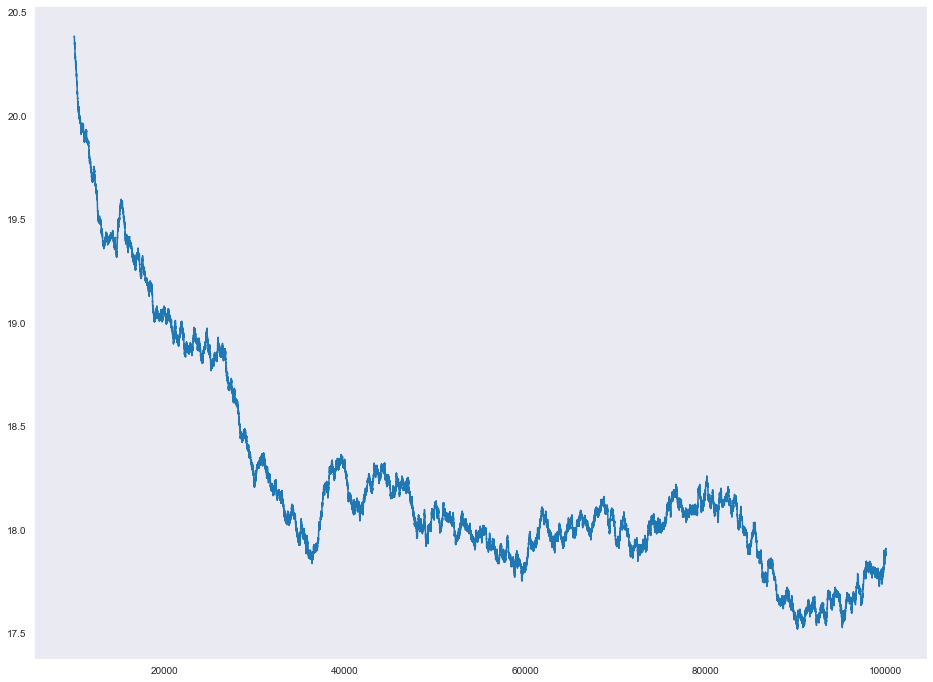

In [26]:
model = LogRegressor()
acc = model.iterate_file()
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());
print("Option 1 is correct")

<font color="red">Question 7.</font> Find the closest answer to the printed accuracy from the following list?

<font color="red">Options:</font>
1. 0.59
2. 0.69
3. 0.79
4. 0.82

## 8. Most important words for a tag

Linear models are easy to interpretate. Please find the most important words for each tag and answer the question.

In [27]:
model._vocab_inv = dict([(v, k) for (k, v) in model._vocab.items()])

for tag in model._tags:
    print(tag, ':', ', '.join([model._vocab_inv[k] for (k, v) in 
                               sorted(model._w[tag].items(), 
                                      key=lambda t: t[1], 
                                      reverse=True)[:5]]))    

c# : simplerpgconsole, type_answer_id, usg, mailingpartner, leases
javascript : x30, x37, x42, x32, x20
c++ : avrf, floatmatrix, w64, dequearray, lucian
jquery : premierequestrian, wmg, dbvendor, 64999389648437, palegreen
ios : u0f0b, libguava, pjsua_aud, 100005440749818, juniors
android : gameasset, exampleproguard, 2508, emulator64, v20161221155621
php : calling_code, x5c, ns__createplantype, rolelevel, dial_code
python : tournamentlist, phi_, mu_ado_2, suseptible, ccompile
java : bitsize, 20269, camobjcoord, decomp, 2677
html : wmg, twentythirteen, 64999389648437, typer, 5046


<font color="red">Question 8.</font> For many tags, the presence of the tag itself in the sentence is an important signal, for them the tag itself is the strongest signal, which is not surprising. For which of the tags is the set of tags, the name of the tag itself is not in the top 5 most important?

<font color="red">Options:</font>
1. c# 
2. javascript
3. jquery
4. android

## 9. Reduce the size of the vacabulary
Currently we have 519290 words in the vacabulary. If it would be full StackOverflow dump, there would be 10 millions of words. We can regularize models not only using mathematics (e.g. `L1` and `L2`), but using empirical knowledge. For example we know that there are many stop words, emojis and just non informative words. So let's reduce ste size of the vacabulary manually.

Your job is to modify `LogRegressor`:
- add to the method `iterate_file` one more argument with default value `update_vocab=True`
- with `update_vocab=True` model can add new words to the vacabulary
- with `update_vocab=False` model should ignore all words which are not presented in the vacabulary
- add method `filter_vocab(n=10000)`, which would keep only top-n most popular words using data from `train`

In [28]:
# UPDATE LogRegressor CLASS
# Put the new version of the class here
# FILL GAP IN THE CODE

In [29]:
model = LogRegressor()
acc = model.iterate_file(update_vocab=True)
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

TypeError: iterate_file() got an unexpected keyword argument 'update_vocab'

In [ ]:
# let's keep only 10 000 words
model.filter_vocab(n=10000)

In [ ]:
# do one more pass over dataset, with reduced learning rate
acc = model.iterate_file(update_vocab=False, learning_rate=0.01)
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

<font color="red">Question 9.</font> Find the closest answer to the printed accuracy from the following list? 

<font color="red">Options:</font>
1. 0.48
2. 0.58
3. 0.68
4. 0.78

## 10. Predic tags for a new question

The last task is to write a function `predict_proba`, which take a string as input, returns a list of predicted tags with their probabilities.

In [ ]:
# UPDATE LogRegressor CLASS
# Put the new version of the class here
# FILL GAP IN THE CODE

In [ ]:
model = LogRegressor()
acc = model.iterate_file(update_vocab=True)
print('%0.2f' % acc)
model.filter_vocab(n=10000)
acc = model.iterate_file(update_vocab=False, learning_rate=0.01)
print('%0.2f' % acc)

In [ ]:
sentence = ("I want to improve my coding skills, so I have planned write " +
            "a Mobile Application.need to choose between Apple's iOS or Google's Android." +
            " my background: I have done basic programming in .Net,C/C++,Python and PHP " +
            "in college, so got OOP concepts covered. about my skill level, I just know " +
            "concepts and basic syntax. But can't write complex applications, if asked :(" +
            " So decided to hone my skills, And I wanted to know which is easier to " +
            "learn for a programming n00b. A) iOS which uses Objective C B) Android " + 
            "which uses Java. I want to decide based on difficulty " + 
            "level").lower().replace(',', '')

In [ ]:
sorted(model.predict_proba(sentence).items(), 
       key=lambda t: t[1], reverse=True)

<font color="red">Вопрос 10.</font> Choose all tags, using threshold equal to $0.9$. 

<font color="red">Options (multiple):</font>
1. android
2. ios
3. php
4. java